# The Evolution and Effect of the 3-Point Shot in the NBA
## By: Rahul Shah 
## Introduction 
In 1980, the National Basketball Association (NBA) introduced the 3-point line. In basketball, all scored baskets count as 2-Points, but with the [inception of the 3-Point line](https://www.usab.com/youth/news/2011/06/the-history-of-the-3-pointer.aspx), which is approximately 25 feet away from the basket, a more valauble, yet more difficult shot was introduced.  At the time it was considered insignificant, however over time we have seen a drastic increase on the reliance of the three pointer, and today is considered an [important part of any team's gameplan](https://hoopshabit.com/2015/01/04/nba-importance-3-pointer/). Through their dominance in the mid to late 2010s, the Golden State Warriors have been recognized as having revolutionized the game and making the three pointer a must-have attribute. The logic is simple: a three-point shot is worth more than a 2-point shot, so if a team can make enough 3-point shots, this will outweigh the 2-pointers. However, there have been questions raised about the effectiveness of shooting many 3 pointers, and if it truly translates into a winnning strategy. 



In this analysis, I will evaluate the increase in three point shots taken since the introduction of the 3-point line, and how/if taking more three-pointers translates into more victories. Some questions that will be answered:

    - How has scoring changed with the introduction of the 3-point line? Is there more points being scored now than prior? 
    - How has the 3-point shot affected a team's ability to succeed? Do successful teams convert the 3-point shot at a high rate? 

 

##  Gathering Data 
All of the libraries needed for this tutorial to scrape, tidy, analyze and visualize the data are imported here. 

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn
from bs4 import BeautifulSoup
import requests
import statsmodels.api as sm 
from sklearn.linear_model import LinearRegression

## Source for Data
I scraped data for each season since 1980 from [Basketball Reference](basketball-reference.com). When I initially tried to scrape from that website, I noticed the tables were not included in the static HTML. Fortunately, they provided an embedded link for the tables I needed, which I used to scrape the data I wanted. The dataset on each table was for an individual season, so to gather multiple seasons' worth of data, I had to iterate through every year, updating the link as I scrape. 

There were two tables for each season that I wanted. One had the total stats for each team (i.e total 3-Points attempted, number of games, etc.), and the other for their wins and losses. I merged the two tables after tidying up some data. Some teams had a `*` next to their names denoting that they were a playoff team. This changes every season so I had to remove this to ensure the team names aligned season by season. 




In [2]:
year = 1980
df = None 
# Function to remove asteriks from team name for uniformity
def remove_asteriks(df): 
    for i in df.index: 
        t = df.at[i, "Team"]
        if '*' in t: 
            df.at[i, 'Team'] = t[0:len(t)-1]
    return df

# Iteration to obtain data for each season 
for year in range(1980, 2022):
    stats_url = f'https://widgets.sports-reference.com/wg.fcgi?css=1&site=bbr&url=%2Fleagues%2FNBA_{year}.html&div=div_team-stats-base'
    standings_url = f'https://widgets.sports-reference.com/wg.fcgi?css=1&site=bbr&url=%2Fleagues%2FNBA_{year}.html&div=div_misc_stats'

    # First iteration, base case
    if df is None: 
        df = pd.read_html(stats_url)[0]
        df['Season'] = year 
        win_loss = pd.read_html(standings_url)[0]
        win_loss.columns = win_loss.columns.droplevel(0)
        win_loss = remove_asteriks(win_loss)[['Team', 'W', 'L']]
        remove_asteriks(df)
        df = df.merge(win_loss, on='Team')

    # Rest of loop, have to concatenate to merge tables 
    else: 
        temp = pd.read_html(stats_url)[0]
        temp['Season'] = year 
        win_loss = pd.read_html(standings_url)[0]
        win_loss.columns = win_loss.columns.droplevel(0)
        win_loss = remove_asteriks(win_loss)[['Team', 'W', 'L']]
        remove_asteriks(temp)
        temp = temp.merge(win_loss, on='Team')
        df = pd.concat([df, temp])

# The tables from the link provides League Average data for some statistics
# I remove this, and will calculate it on my own later, if necessary
df = df[df.Team != 'League Average']
df['win_pct'] = df['W'] / df['G']
df = df[['Team', 'G', 'W', 'L', 'win_pct', 'FG', 'FGA', 'FG%', '2P', '2PA', '2P%', '3P', '3PA', '3P%', 'PTS', 'Season']]
df 



,Team,G,W,L,win_pct,FG,FGA,FG%,2P,2PA,2P%,3P,3PA,3P%,PTS,Season
0,San Antonio Spurs,82,41.0,41.0,0.500000,3856,7738,0.498,3804,7532,0.505,52,206,0.252,9788,1980
1,Los Angeles Lakers,82,60.0,22.0,0.731707,3898,7368,0.529,3878,7268,0.534,20,100,0.200,9438,1980
2,Cleveland Cavaliers,82,37.0,45.0,0.451220,3811,8041,0.474,3775,7854,0.481,36,187,0.193,9360,1980
3,New York Knicks,82,39.0,43.0,0.475610,3802,7672,0.496,3760,7481,0.503,42,191,0.220,9344,1980
4,Boston Celtics,82,61.0,21.0,0.743902,3617,7387,0.490,3455,6965,0.496,162,422,0.384,9303,1980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25,New York Knicks,72,39.0,31.0,0.541667,2839,6225,0.456,1992,4062,0.490,847,2163,0.392,7706,2021
26,Detroit Pistons,72,20.0,51.0,0.277778,2783,6162,0.452,1951,3792,0.515,832,2370,0.351,7676,2021
27,Oklahoma City Thunder,72,21.0,50.0,0.291667,2795,6338,0.441,1938,3809,0.509,857,2529,0.339,7560,2021
28,Orlando Magic,72,21.0,50.0,0.291667,2754,6423,0.429,1970,4135,0.476,784,2288,0.343,7488,2021


## Data Exploration and Analysis 

After scraping and tidying the dataset, I first decided to explore the progression of the two different shot attempts over time. Because of the fluctuating number of games in some seasons, I plotted the league average number of shot attempts per game for each season. Some seasons had less games played so looking just at the average total attempts for the season would not be consistent. For example, in the 1998-99 season the totals for 3-point attempts were less than the surrounding years, however, the number of 3-point shots attempted per game was larger than previous seasons. 

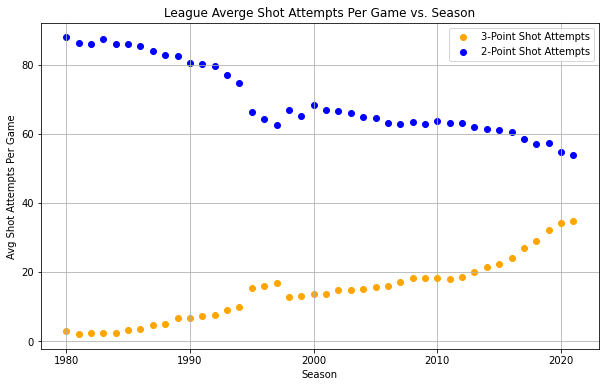

In [3]:
# We want league averages for each season 
avg = df.groupby('Season').mean()
fig, ax = plt.subplots(figsize=(10,6))
# Per game statistic calculation
avg['3PAPG'] = avg['3PA'] / avg['G']
avg['2PAPG'] = avg['2PA'] / avg['G']
x = avg.index

# Plot Setup 
ax.scatter(x, avg['3PAPG'], color='orange', label='3-Point Shot Attempts')
ax.scatter(x, avg['2PAPG'], color='blue', label='2-Point Shot Attempts')
ax.legend()
ax.grid(True)
plt.xlabel('Season')
plt.ylabel('Avg Shot Attempts Per Game')
plt.title('League Averge Shot Attempts Per Game vs. Season')
plt.show()

What is obvious in the plot above is the decrease in number of 2-point attempts and an increase in 3-point attempts over time. There was a steady increase of 3-pointers from 1980 to 2012, with a drastic increase occurring in the mid-late 2010s. 

Now, with the increase in 3-point attempts, how would this affect overall points scored? With higher-valued (in terms of points) shots being taken more often, can we expect an increase in points scored? Once again, I will use a 'per game' average for points and attempts to fairly compare the different seasons. 

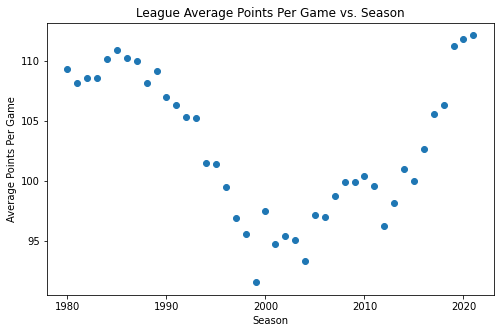

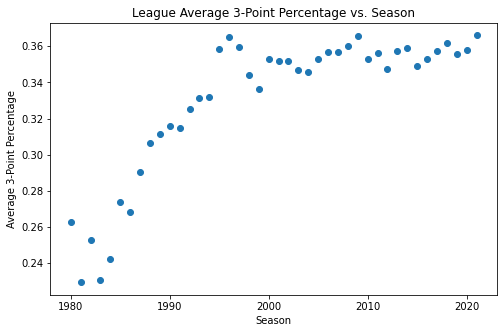

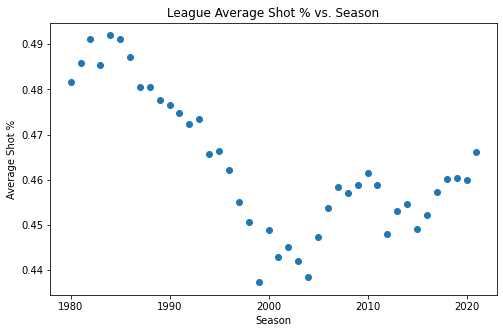

In [4]:
# Calculations for points per game
avg['PPG'] = avg['PTS'] / avg['G']

# Three separate plots to identify growth of each statistic over time
x = avg.index 
plt.figure(figsize=(8,5))
plt.xlabel('Season')
plt.ylabel('Average Points Per Game')
plt.title('League Average Points Per Game vs. Season')
plt.scatter(x, avg['PPG'])
plt.show()


plt.figure(figsize=(8,5))
plt.xlabel('Season')
plt.ylabel('Average 3-Point Percentage')
plt.title('League Average 3-Point Percentage vs. Season')
plt.scatter(x, avg['3P%'])
plt.show()

plt.figure(figsize=(8,5))
plt.xlabel('Season')
plt.ylabel('Average Shot %')
plt.title('League Average Shot % vs. Season')
plt.scatter(x, avg['FG%'])
plt.show()


From the plots above, we first observe an initial decrease in points per game from the 90s into the 2000s, even though 3-point shot attempts have increased over this time. This can be attested to an overall lower shot % (of both 2-point shots and 3-point shots). However, the points per game drastically increased with shooting percentages coming back up, along with the drastic increase in 3-point shot attempts without a drop in the 3-point shooting percentage. Basically, the harder, longer range 3-point shot was being using more often with enough consistensy which helped to increase the points per game statistic. 

Now, I would like to explore teams' success with the 3-point shot and how or if that has factored in to the team's overall success. Is the 3-point shot helping them win games? Is it truly better to shoot more threes to win games? Because of the recent (last 10 years) increase in 3-point shot attempts, I will only evaluate the success of teams and their 3-point shot usage from the last 10 years. 

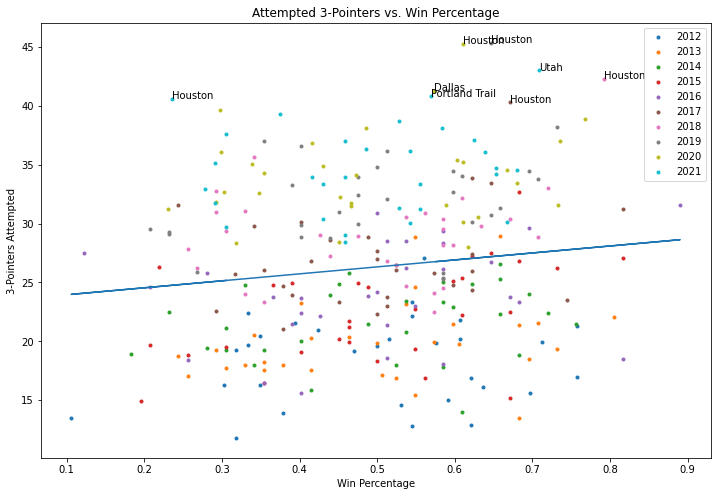

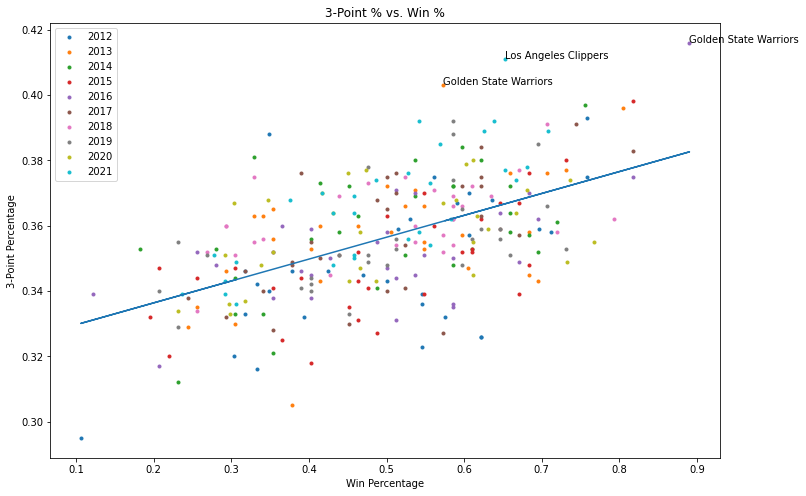

In [5]:
year = 2012
df['3PAPG'] = df['3PA'] / df['G']
# Slice of Data, we only want the last 10 years 
recent = df[lambda df: df['Season'] >= year]


plt.figure(figsize=(12,8))
plt.xlabel('Win Percentage')
plt.ylabel('3-Pointers Attempted')
plt.title('Attempted 3-Pointers vs. Win Percentage')
for year in range(2012,2022):
    curr = recent.groupby('Season').get_group(year)
    plt.scatter(marker='.', x=curr['win_pct'], y=curr['3PAPG'], label=str(year))
plt.legend()

# Labeling teams that have shown strong 3-Point shooting percentages
for i, txt in enumerate(recent['Team']):
    if (recent.iloc[i]['3PAPG']) >= 40:
        # Keeping only city name to reduce text overlap 
        city = txt.split()
        plt.annotate(' '.join(city[0:len(city)-1]), (recent.iloc[i]['win_pct'], recent.iloc[i]['3PAPG']))

# Regression Line 
win_pct = np.array(recent['win_pct']).reshape(-1,1)
three_pa = np.array(recent['3PAPG']).reshape(-1,1)
reg = LinearRegression().fit(win_pct, three_pa)
plt.plot(win_pct, reg.intercept_ + reg.coef_ * win_pct, '-')
plt.show()

# Second plot
plt.figure(figsize=(12,8))
for year in range(2012,2022):
    curr = recent.groupby('Season').get_group(year)
    plt.scatter(marker='.', x=curr['win_pct'], y=curr['3P%'], label=str(year))
plt.xlabel('Win Percentage')
plt.ylabel('3-Point Percentage')
plt.title('3-Point % vs. Win %')
plt.legend() 

for i, txt in enumerate(recent['Team']):
    if (recent.iloc[i]['3P%']) >= .4:
        plt.annotate(txt, (recent.iloc[i]['win_pct'], recent.iloc[i]['3P%']))

three_perc = np.array(recent['3P%']).reshape(-1,1)
reg = LinearRegression().fit(win_pct, three_perc)
plt.plot(win_pct, reg.intercept_ + reg.coef_ * win_pct, '-')


plt.show()


This data does not seem to be decesive enough to confirm our hypothesis that 3-Pointers translate into wins. There are teams that shoot very few three pointers per game but still have high win percentage in a season. There are some outliars in our dataset that are true to our hypothesis, like some of the labeled teams shown above. The Golden State Warriors, in multiple instances have had a high win percentage while shooting well above the average 3-point percentage. 

## Standardization and Modeling 

As the overall number of 3-Point shots and 3-point percentages has fluctuated season by season, it looks like comparing these statistics across different years is problematic. So, instead of comparing percentage across multiple years, it could be beneficial to standardize the data to compare shooting percentages relative to other teams in the same year. 

First, I use a violin plot to demonstrate the distribution of of data year by year.

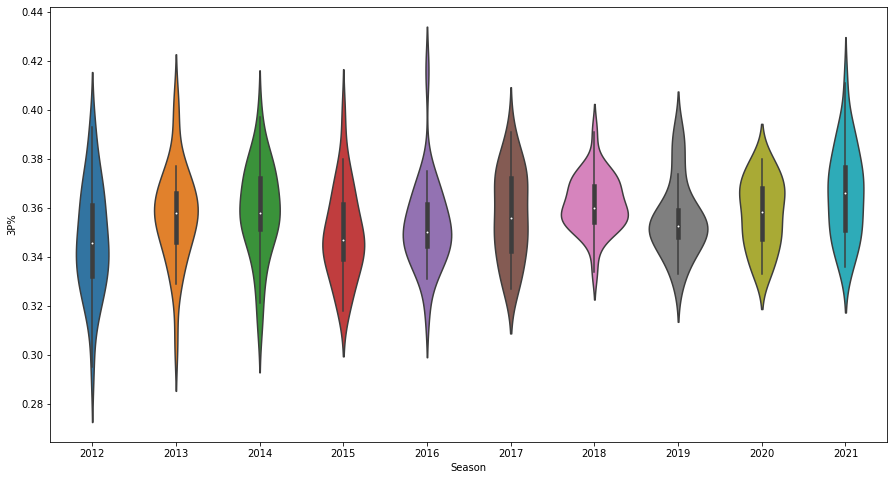

In [6]:
plt.figure(figsize=(15,8))
seaborn.violinplot(x=recent['Season'], y=recent['3P%'])
plt.show()

In most instances, the data appears to be normally distributed, unimodal and not skewed too far to one side. The median point for each violin is also at the center of the violin, further confirming the normal distribution. 

Year over year, more 3-point shots have been taken by each team, so I will standardize 3-Point % by year. The equation will look similar to the one in the Moneyball project as shown below.

for team `i` in year `j`:
## $standardized\_3pt\_percentage_{ij} = \frac{3pt\_percentage_{ij} - avg\_3pt\_percentage_j}{s_j}$

where *avg_3pt_percentage<sub>j</sub>* is the average 3-point percentage for year `j` and *s<sub>j</sub>* is the standard deviation of 3-point percentage for year `j`

In [7]:
standardized = [] 
for s in recent['Season'].unique():
    curr_year = recent[lambda df: df['Season'] == s]
    mean = curr_year['3P%'].mean() 
    std = curr_year['3P%'].std() 

    temp = curr_year[['Team', '3P%', 'win_pct', 'Season']].copy() 
    temp['standardized_3P%'] = (temp['3P%'] - mean) / std

    if len(standardized) == 0: 
        standardized = temp.copy()  
    else: 
        standardized = pd.concat([standardized, temp])
standardized

,Team,3P%,win_pct,Season,standardized_3P%
0,Denver Nuggets,0.332,0.575758,2012,-0.687269
1,San Antonio Spurs,0.393,0.757576,2012,2.064814
2,Oklahoma City Thunder,0.358,0.712121,2012,0.485750
3,Utah Jazz,0.323,0.545455,2012,-1.093314
4,Milwaukee Bucks,0.345,0.469697,2012,-0.100759
...,...,...,...,...,...
25,New York Knicks,0.392,0.541667,2021,1.405040
26,Detroit Pistons,0.351,0.277778,2021,-0.813444
27,Oklahoma City Thunder,0.339,0.291667,2021,-1.462757
28,Orlando Magic,0.343,0.291667,2021,-1.246319


The calculations for standardized three point percentage will help us see where teams fall with respect to the average in their 3-point shot making ability. A standardized 3pt % < 0 would indicate below average 3-point shot making ability, and a positive value would indicate above average shot making ability.   

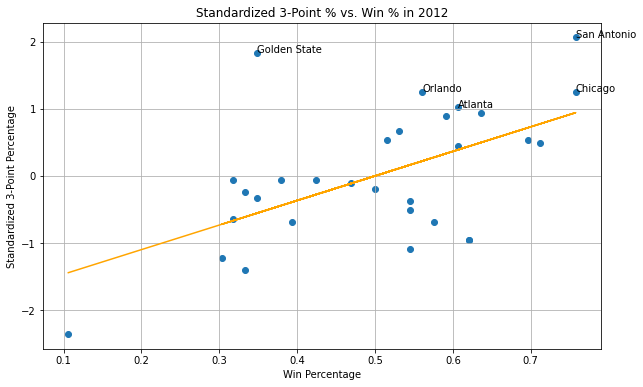

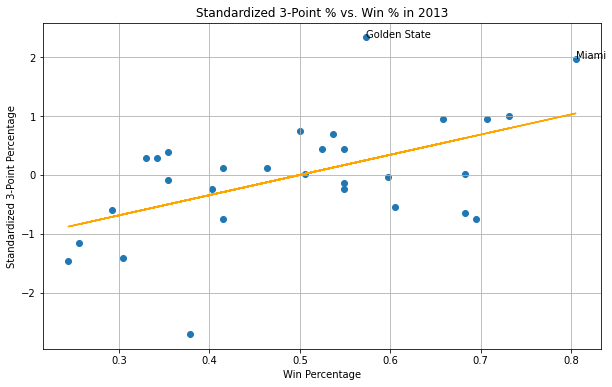

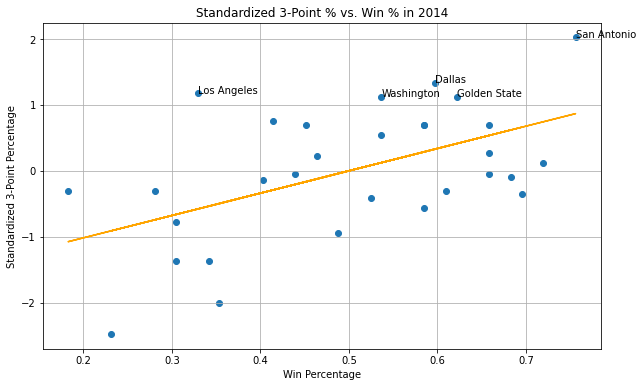

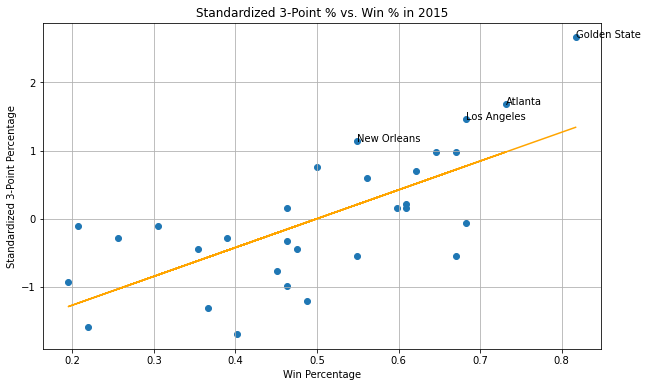

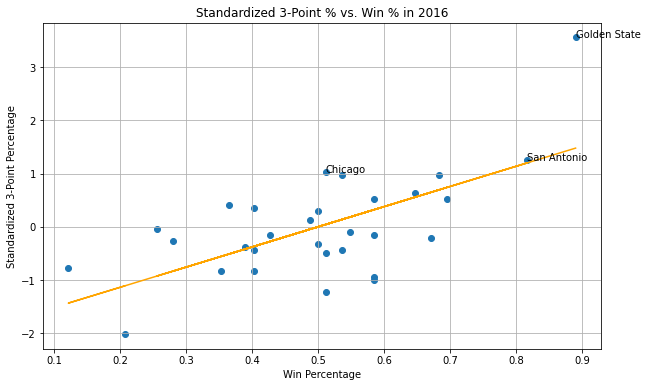

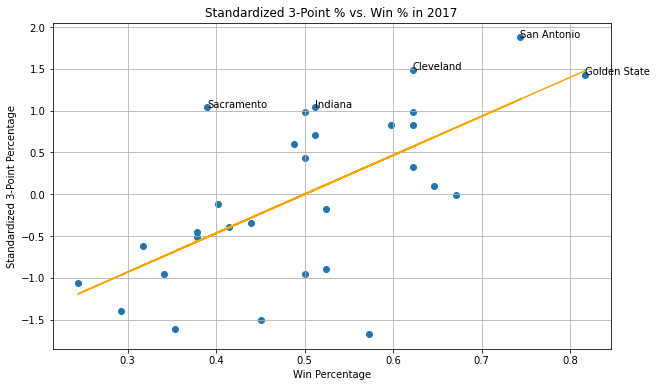

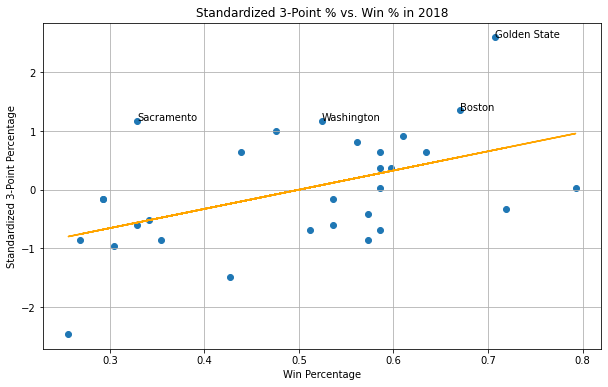

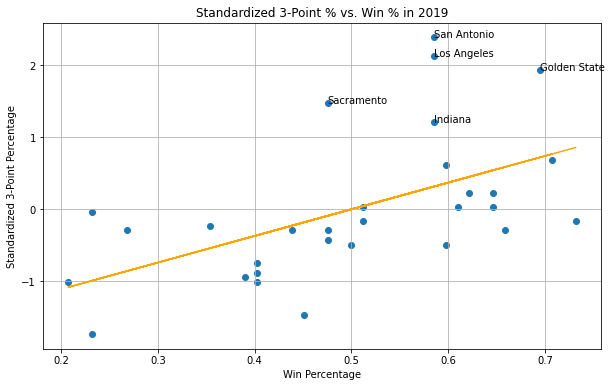

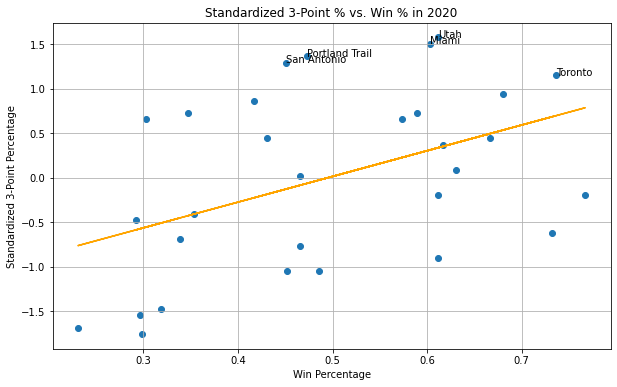

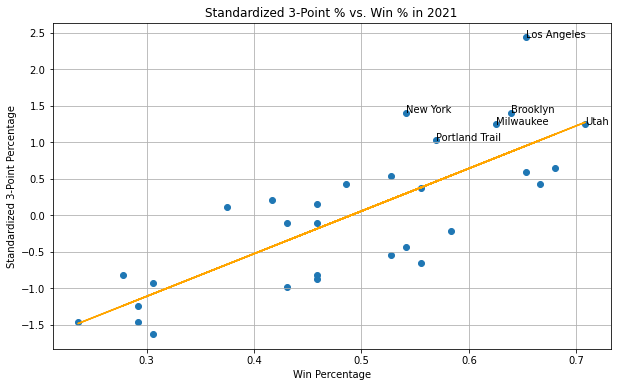

In [8]:
for s in standardized['Season'].unique(): 
    plt.figure(figsize=(10,6))
    curr_year = standardized[lambda df: df['Season'] == s]
    plt.xlabel('Win Percentage')
    plt.ylabel('Standardized 3-Point Percentage')
    plt.title(f'Standardized 3-Point % vs. Win % in {s}')
    plt.scatter(x=curr_year['win_pct'], y=curr_year['standardized_3P%'])

    win_pct = np.array(curr_year['win_pct']).reshape(-1,1)
    std_3p = np.array(curr_year['standardized_3P%']).reshape(-1,1)
    reg = LinearRegression().fit(win_pct, std_3p)
    for i, txt in enumerate(curr_year['Team']):
        if (curr_year.iloc[i]['standardized_3P%']) > 1:
            city = txt.split()
            plt.annotate(' '.join(city[0:len(city)-1]), (curr_year.iloc[i]['win_pct'], curr_year.iloc[i]['standardized_3P%']))
    plt.plot(win_pct, reg.intercept_ + reg.coef_ * win_pct, '-', color='orange')
    plt.grid(True)

Once again, we see that the results are mixed. There are teams in all years who have below average 3-point percentages, yet still maintain high winning percentages. We now use the `statsmodel` library to officially confirm or deny our hypothesis. 

In [9]:
for s in standardized['Season'].unique():
    curr_year = standardized[lambda df: df['Season'] == s]
    win_pct = np.array(curr_year['win_pct']).reshape(-1,1)
    std_3p = np.array(curr_year['standardized_3P%']).reshape(-1,1)
    est = sm.OLS(std_3p, win_pct)
    print(f'Results for: {s}\n{est.fit().summary()}\n\n')

Results for: 2012
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.028
Model:                            OLS   Adj. R-squared (uncentered):             -0.005
Method:                 Least Squares   F-statistic:                             0.8385
Date:                Mon, 17 May 2021   Prob (F-statistic):                       0.367
Time:                        13:54:43   Log-Likelihood:                         -41.632
No. Observations:                  30   AIC:                                      85.26
Df Residuals:                      29   BIC:                                      86.67
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------

## Conclusion 

What we see is that there is a very high p-value for each year. This means that high 3-point percentages do not necessarily translate into more wins for a team (i.e winning percentage). We reject our hypothesis that high 3-point percentages can translate into more success/a higher winning percentages for teams. Instead, we retain the null hypothesis that shooting 3-point shots at a high rate are not the only way to win. The effectiveness of the Golden State Warriors from the years 2015-2019 seems to be more of an anomaly than it is the status quo. We observe that other teams, like Sacramento in multiple years and Los Angeles in 2014 that have had well above average 3-point percentages, yet were unsuccessful, with winning percentages below 50%. 

A popular basketball adage, [*Live by the three, die by the three*](https://fivethirtyeight.com/features/live-by-the-three-die-by-the-three-is-mostly-a-myth/) is more of a myth than fact. There is more to winning in basketball than just making 3-pointers. Scoring in basketball comes in a lot of different ways, and as seen in the beginning of this tutorial, points per game in fact dropped off although more 3-pointers were taken; this occurred due to the fact that teams were not making as many shots (both 2-pt and 3-pt) as a whole.  

If I were to further this tutorial, after acknowledging that 3-point performance may not be the sole secret to an NBA team's success, I would consider other factors like defensive ability and offensive effectiveness to see how they correlated to winning. [Here is how FiveThirtyEight](https://fivethirtyeight.com/methodology/how-our-nba-predictions-work/), a popular analytical website creates their own win projections for the NBA. As you can see, there is a lot more that could be taken into account to determine a team's success.  

For further insight, here is an [article](https://www.wsj.com/articles/the-golden-state-warriors-have-revolutionized-basketball-1459956975) from the Wall Street Jornal on how the Golden State Warriors have revolutionzed basketball with their approach to the game. 